In [ ]:
# Callin Switzer
# 9 Sept 2019
# python infrared reader

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import serial
import re
import csv
import seaborn as sns
import warnings
import sys
import os
from datetime import datetime
import glob
import time
import io

In [2]:
def is_mac():
    mac = True if sys.platform == "darwin" else False
    return(mac)
    
if not is_mac():
    import msvcrt
    import winsound

In [3]:
%matplotlib inline
print(sys.version)
print(sys.executable)

# define directories
baseDir = os.getcwd()

# data for storing datafile
dataDir = r"C:\Users\callin\Desktop\MonarchData"
if not os.path.isdir(dataDir):
    os.mkdir(dataDir)

figDir = r"C:\Users\callin\Desktop\MonarchFigs"
if not os.path.isdir(figDir):
    os.mkdir(figDir)

3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
/Users/cswitzer/anaconda3/envs/photogate/bin/python


In [4]:
def serial_ports():
    """ Lists serial port names
        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

# list serial ports
serial_ports() # this arduino is on COM6

['/dev/tty.Bluetooth-Incoming-Port', '/dev/tty.usbmodem14101']

In [5]:
# connect to arduino
PORT1 = '/dev/tty.usbmodem14101'

connected1 = False
if "ser1" in globals():
    ser1.close()
    
ser1 = serial.Serial(PORT1, 115200, timeout=1.0) # stop if no data comes in 1 second
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print("connected to arduino on " + PORT1)
serin1 = ser1.readline()
print(serin1.decode("utf-8")) # should say "setup complete"

connected to arduino on /dev/tty.usbmodem14101
 Setup complete



In [6]:
# ser1.close() # close serial connection

In [22]:
ctr = 0
maxTime = 75 # minutes


if not is_mac():
    while msvcrt.kbhit():
        msvcrt.getch()
        print('clearing characters ...')
        
# turn off data collection if it's already started
ser1.write("c".encode("utf-8")) # sending something that's not "r" tell arduino to stop recordin

# read all data in the incoming buffer to clear it
# note that this might take a second or two 
ser1.readlines() 

# sending an "r" tells the arduino so start sending data
ser1.write("r".encode("utf-8"))
while True:
    if not is_mac():
        if msvcrt.kbhit(): # if q, or escape is pressed, then break the loop
            k = msvcrt.getch()
            if(k == b'q') | (k == b'\x1b') | (k == b'\x0b') :
                print("keyboard break")
                winsound.MessageBeep()
                break
            

    if ctr == 0:
        
        minuteCounter = 0
       
        # tell arduino to write data to serial
        # discard first read line, in case it's the wrong length
        ser1.readline()
        
        txt = ser1.readline().decode("utf-8")
        txt2 = (txt).rstrip().split(",") 
        colNames = ["A" + str(ii) for ii in range(len(txt2) -1)]
        colNames.append("ardno_usec_snce_lst_read")
        colNames.append("python_datetime")
        
        # make file  and write header
        fileStart = datetime.now()
        fname = (fileStart.strftime('%Y-%m-%d %H:%M:%S.%f'))
        fname = re.sub(r'[^\w\s]','_',fname)
        fname = re.sub(" ", "__", fname)[0:] + ".csv"

        with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerows([colNames])
            
            
    
    
    # read data
    txt = ser1.readline().decode("utf-8")
    line_to_write =  (txt + "," + datetime.now().
                  strftime('%Y-%m-%d %H:%M:%S.%f')).rstrip().split(",")  

    # check data before writing
    if (len(line_to_write) != len(colNames)):
        print("data length is different from length of columns, dropping a reading")
        print(line_to_write)
        print(colNames)
        print(ctr)
        continue
        
    elif (np.max(list(map(int, line_to_write[:-3]))) > 1023):
        print("data range incorrect, dropping a reading")
        continue
    
    else:
        with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerows([line_to_write])

    # print time
    readTime = datetime.now()
    c = readTime - fileStart
    if c.total_seconds()//60 == minuteCounter:
        print("Time elapsed (minutes):", minuteCounter)
        minuteCounter += 5 # print every 5 minutes
    
    if divmod(c.days * 86400 + c.seconds, 60)[0] >= maxTime:
        break   
    
    # update ctr
    ctr += 1

# stop data collection
ser1.write("c".encode("utf-8"))

print('done')

Time elapsed (minutes): 0


KeyboardInterrupt: 

In [16]:
#ser1.write("c".encode("utf-8"))

In [17]:
# ser1.readline().decode("utf-8") # checks to see if there's incoming data

'174,195,259,260,304,307,20000\n'

In [23]:
# tells the num of minutes
c.total_seconds()/60

0.15231065

In [24]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# look at data
# read in data
dfile = os.path.join(dataDir,fname)
df1 = pd.read_csv(dfile)
#df1 = df1.iloc[1500:2000,:].copy()
df1['python_datetime']= pd.to_datetime(df1['python_datetime'])
print(df1.shape)
df1.tail()

(457, 8)


,A0,A1,A2,A3,A4,A5,ardno_usec_snce_lst_read,python_datetime
452,174,182,249,258,315,321,20000,2019-09-10 13:03:57.259685
453,174,182,249,254,305,307,20000,2019-09-10 13:03:57.279963
454,174,182,249,249,298,294,20000,2019-09-10 13:03:57.300630
455,174,182,250,250,295,298,20000,2019-09-10 13:03:57.320664
456,174,182,249,254,310,310,20000,2019-09-10 13:03:57.341479


In [25]:
tot_sec = np.array(df1.python_datetime.iloc[[0,-1]].diff() / np.timedelta64(1, 's'))[1]
print("avg sample per sec: ", df1.shape[0] / tot_sec)

avg sample per sec:  50.12153100329266


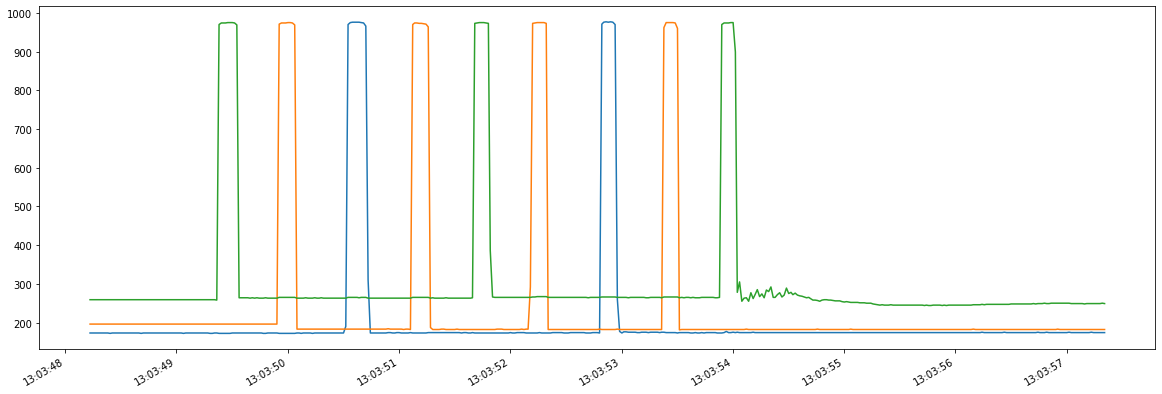

In [26]:
fig, ax = plt.subplots(1,1, figsize = [20,7])
for ii in range(3):
    ax.plot(df1.python_datetime, df1.iloc[:,ii])
fig.autofmt_xdate()
plt.show()

In [27]:
fname

'2019_09_10__13_03_48_203403.csv'

Text(0.5, 0, 'sample num')

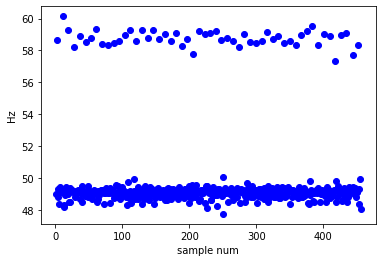

In [28]:
# calculate sampling rate, based on python timestamp
timeDiff = df1.python_datetime.diff() / np.timedelta64(1, 's')
plt.plot(1/timeDiff, 'bo')
plt.ylabel("Hz")
plt.xlabel("sample num")

Text(0, 0.5, 'microseconds between samples')

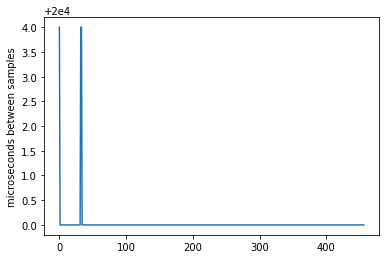

In [29]:
# show sampling rate from arduino
plt.plot(df1.ardno_usec_snce_lst_read)
plt.ylabel("microseconds between samples")

Text(0.5, 0, 'Sample')

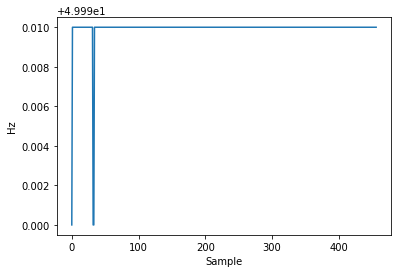

In [30]:
# show sampling rate from arduino
plt.plot(1/np.array(df1.ardno_usec_snce_lst_read)*10**6)
plt.ylabel('Hz')
plt.xlabel("Sample")

In [31]:
ser1.close()

In [ ]:
# int.from_bytes(b'\n', byteorder='big')